# 7. Using a pretrained convnet

작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다. 사전 훈련된 네트워크(pretrained network)는 일반적으로 대규모 이미지 분류 문제를 우해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다. 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다. 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용합니다. 예를 들어 (대부분 동물이나 생활 용품으로 이루어진) ImageNet 데이터셋에 네트워크를 훈련합니다. 그다음 이 네트워크를 이미지에서 가구 아이템을 식별하는 것 같은 다른 용도로 사용할 수 있습니다. 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점입니다. 이런 방식으로 작은 데이터셋을 가진 문제에도 딥러닝이 효율적으로 작동할 수 있습니다.  

여기에서는 (1,400만개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용해 보겠습니다. ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 비롯하여 많은 동물들을 포함하고 있습니다. 그래서 강아지와 고양이 분류 문제에 좋은 성능을 낼 수 있을 것 같습니다.  

VGG16구조는 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조입니다. VGG16은 조금 오래되었고 최고 수준의 성능에는 못 미치며 다른 모델보다는 조금 무겁습니다. 하지만 이 모델의 구조가 이전의 보았던 것과 비슷하고 새로운 개념을 도입하기 않고 이해하기 쉽습니다. 이런 이름에는 VGG, ResNet, Inception, Inception-ResNet, Xception등이 있습니다.  

사전 훈련된 네트워크를 사용하는 두 가지 방법이 있습니다. 특성 추출(feature extraction)과 미세 조정(fine tuning)입니다. 이 2가지를 모두 다루어 보겠습니다. 먼저 특성 추출부터 시작하겠습니다.

## Setup

In [4]:
%run setup.py

<br>

# 7.1 Feature extraction

특성 추출은 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다.  

앞서 보았듯이 컨브넷은 이미지 분류를 위해 두 부분으로 구성됩니다. 먼저 연속된 합성곱과 풀링 층으로 시작해서 완전 연결 분류기로 끝납니다. 첫 번째 부분을 모델의 합성곱 기반층(convolution base)라 부르겠습니다. 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고, 그 출력으로 새로운 분류기를 훈련합니다(아래 그림 참고).

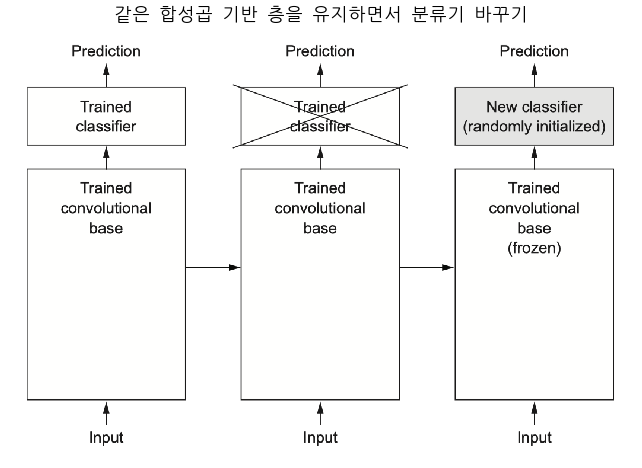

In [5]:
plt.figure(figsize=(12, 8))
plt.title("같은 합성곱 기반 층을 유지하면서 분류기 바꾸기", fontsize=18)
plot_external2("./images/ch07/1.png")
plt.show()

합성곱 층만 재사용고 완전 연결 분류기를 재사용하지 않는 이유는 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용이 가능하기 때문입니다. 컨브넷의 특성 맵은 사진에 대한 일반적인 콘셉트의 존재 여부를 기록한 맵입니다. 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있습니다. 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다. 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만 담고 있습니다. 더군다나 완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 객체의 위치 정보를 가지고 이찌 않습니다. 완전 연결 층들은 공간 개념을 제거하지만 합성곱의 특성 맵은 객체 위치를 고려합니다. 객체 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모가 없습니다.  

특정 합성곱 층에서 추출한 표현의 일반성(그리고 재사용성) 수준은 모델에 있는 층의 깊이에 달려 있습니다. 모델의 하위 층은 (에지, 색깔, 질감 등) 지역적이고 매우 일반적인 특성 맵을 추출합니다.반면에 상위 층은 ("강아지 눈"이나 "고양이 귀"처러) 좀 더 추상적인 개념을 추출합니다. 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다는 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋습니다.  

ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있습니다. 이런 경우 원본 모델의 완전 연결 층ㅇ 있는 정보를 재사용하는 것이 도움이 될 것 같습니다. 하지만 새로운 문제의 클래스가 원본 모델의 클래스 집합과 겹치지 않는 좀 더 일반적인 경우를 다루기 위해서 여기서는 완전 연결 층을 사용하지 않겠습니다. ImageNet 데이터셋에 훈련된 VGG16 네트워크의 합성곱 기반 층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출해 보겠습니다. 그런 다음 이 특성으로 강아지 vs 고양이 분류기를 훈련합니다.  

VGG16 모델은 케라스에 패키지로 포함되어 잇습니다. `keras.applications` 모듈에서 임포트할 수 있습니다(**Xception, Inception V3, ResNet50, VGG16, VGG19, MobileNet**). 

In [6]:
from tensorflow.keras.applications import VGG16

In [7]:
clear_session()

conv_base = VGG16(weights="imagenet", 
                  include_top=False,
                  input_shape=(150, 150, 3))

W0811 06:09:52.114941 140578647525184 deprecation.py:506] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


VGG16 함수에 3개의 매개변수를 전달합니다.  

- weights는 모델을 초기화할 가중치 체크포인트(checkpoint)를 지정합니다.  
- include_top은 네트워크의 최상위 완전 연결 분류기를 포함할지 안 할지 지정합니다.  
기본값은 ImageNet의 클래스 1,000개에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 2개의 클래스를 구분하는)완전 연결 층을 추가하려고 하므로 이를 초함시키지 않습니다.  
- input_shape은 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택 사항입니다. 이 값을 지정하지 않으면 어떤 크기의 입력도 처리할 수 있습니다. include_top이 True이면 합성곱 위에 완전 연결 층이 추가되기 때문에 input_shape이 원본 모델과 동일한 (224, 224, 3)이 되어야 합니다.  

이 구조는 앞에서 보았던 간단한 컨브넷과 비슷합니다.

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

<br>

최종 맵의 크기는 (4, 4, 512)입니다. 이 특성 위에 완전 연결 층을 놓을 것입니다.  

이 지점에서 2가지 방식이 가능합니다.  
- 새로운 데이터셋에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저정합니다. 그다음 이 데이터를 이 책의 1부에서 보았던 것과 비슷한 독립된 완전 연결 분류기에 입력으로 사용합니다. 합성곱 연산은 전체 과정 중에서 가장 비싼 부분입니다. 이 방식은 모든 입력 이미지에 대해 합성곱 기반 층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 듭니다. 하지만 이런 이유 때문에 이 기법에는 데이터 증식을 사용할 수 없습니다.  
- 준비한 모델(conv_base)위에 Dense 층을 확장합니다. 그다음 입력 데이터에서 end-to-end로 전체모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반 층을 통과하기 때문에 데이터 증식을 사용할 수 있습니다. 하지만 이런 이유로 이 방식은 첫번째 방식보다 훨씬 비용이 많이 듭니다.  

<br>

> 데이터 증식을 사용하지 않는 빠른 특성 추출  

ImageDataGenerator를 사용하여 이미지와 레이블을 넘파이 배열로 추출하고, conv_base 모델의 predict 매서드를 호출하여 이 이미지에서 특성을 추출합니다. 

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
base_dir = "./datasets/dogs_and_cats_small/"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

In [11]:
data_generator = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [12]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = data_generator.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="binary")
    i = 0
    for inputs_batch, labels_batch in generator:
        feature_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = feature_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break # generator는 루프안에서 무한하게 데이터를 만들어 내므로 모든 이미지를 한번씩 처리하고 나면 중지합니다.
    return features, labels

In [13]:
%%time
train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(validation_dir, 500)
test_features, test_labels = extract_features(test_dir, 500)

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
CPU times: user 30min 47s, sys: 10min 9s, total: 40min 57s
Wall time: 23min 54s


<br>

추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다.

In [14]:
train_features = np.reshape(train_features, (1000, 4*4*512))
validation_features = np.reshape(validation_features, (500, 4*4*512))
test_features = np.reshape(test_features, (500, 4*4*512))

In [15]:
from tensorflow.keras import layers, optimizers, losses, metrics

In [16]:
model = tf.keras.Sequential()

model.add(layers.Dense(256, activation="relu", input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))

In [17]:
model.compile(optimizer=optimizers.Adam(lr=2e-5), 
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

W0811 06:33:54.574937 140578647525184 deprecation.py:323] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
n_epochs=30
class_mode="binary_accuracy"
history = model.fit(train_features, train_labels,
                    epochs=n_epochs,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    verbose=0,
                    callbacks=[LossAndError(epochs=n_epochs, class_mode=class_mode, validation=True)])

Epoch 1/30, loss: 0.59108, binary_accuracy: 0.61600
history key: ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
Epoch 6/30, loss: 0.32532, binary_accuracy: 0.87900, val_loss: 0.35775, val_binary_accuracy: 0.85600
Epoch 12/30, loss: 0.22556, binary_accuracy: 0.92700, val_loss: 0.31575, val_binary_accuracy: 0.86600
Epoch 18/30, loss: 0.16211, binary_accuracy: 0.94700, val_loss: 0.29101, val_binary_accuracy: 0.88400
Epoch 24/30, loss: 0.11665, binary_accuracy: 0.97300, val_loss: 0.29083, val_binary_accuracy: 0.88200
Epoch 30/30, loss: 0.09643, binary_accuracy: 0.97700, val_loss: 0.29755, val_binary_accuracy: 0.87800


In [19]:
makedir("./models/ch07")
model.save("./models/ch07/feature_extraction_1.h5")

directory created!!


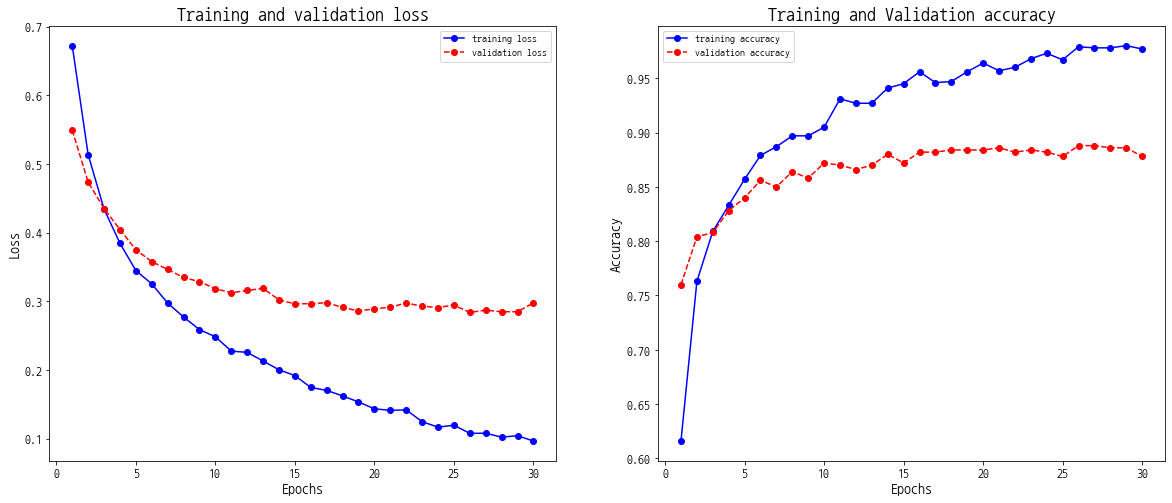

In [20]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

<br>

2개의 Dense층만 처리하면 되기 때문에 훈련이 매우 빠릅니다. 약 85%의 검증 정확도에 도달했습니다. 이전에서 훈련시킨 것보다도 훨씬 좋습니다. 하지만 이 그래프는 드롭아웃을 사용했음에도 훈련을 시작하면서 거의 바로 과대적합되고 있다는 것을 보여줍니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.  

> 데이터 증식을 사용한 특성 추출  

이제 특성 추출을 위해 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다(CPU에서는 매우 느립니다).

In [21]:
from tensorflow.keras import layers

In [22]:
clear_session()

model = tf.keras.Sequential()
conv_base = VGG16(weights="imagenet", 
                  include_top=False,
                  input_shape=(150, 150, 3))

In [23]:
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


<br>

여기서 볼 수 있듯이 VGG16의 합성곱 기반 층은 14,714,688개의 파라미터를 가지고 있습니다. 합성곱 기반 층 위에 추가한 분류기는 200만개의 파라미터를 가집니다.  

**모델을 컴파일하고 훈련하기 전에 합성곱 기반 층을 동결하는 것이 아주 중요합니다.** 하나 이상의 층을 동결(freezing)한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 이렇게 하지 않으면 합성곱 기반 층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다. 맨 위에 Dense 층은 랜덤하게 초기화되었기 때문에 매우 큰 가중치 업데이트 값이 네트워크에 전파될 것입니다. **이는 사전에 학습된 표현을 크게 훼손하게 됩니다.**

In [25]:
print("conv_base를 동결하기 전 훈련되는 가중치의 수: {}".format(len(model.trainable_weights)))

# conv_base를 동결하기 전 훈련되는 가중치의 수:
conv_base.trainable = False
print("conv_base를 동결하기 전 훈련되는 가중치의 수: {}".format(len(model.trainable_weights)))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30
conv_base를 동결하기 전 훈련되는 가중치의 수: 4


이렇게 설정하면 추가한 2개의 Dense층 가중치만 훈련될 것입니다. 층마다 2개씩(가중치 행렬과 편향 벡터)총 4개의 텐서가 훈련됩니다. 변경 사항을 적용하려면 먼저 모델을 컴파일 해야합니다. 컴파일 단계 후에 **trainable 속성을 변경하면 반드시 모델을 다시 컴파일해야 합니다.**

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, metrics, losses

In [27]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")
test_data_generator = ImageDataGenerator(rescale=1./255)

In [28]:
train_generator = train_data_generator.flow_from_directory(train_dir,
                                                           target_size=(150, 150),
                                                           batch_size=20,
                                                           class_mode="binary")
validation_generator = test_data_generator.flow_from_directory(validation_dir,
                                                               target_size=(150, 150),
                                                               batch_size=20,
                                                               class_mode="binary")

Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [29]:
model.compile(optimizer=optimizers.Adam(lr=2e-5), 
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [ ]:
%%time
n_epochs=30
class_mode="binary_accuracy"
history = model.fit_generator(train_generator,
                              steps_per_epoch=50,
                              epochs=n_epochs,
                              validation_data=validation_generator,
                              validation_steps=25,
                              verbose=0,
                              callbacks=[LossAndError(epochs=n_epochs, class_mode=class_mode, validation=True)])

Epoch 1/30, loss: 0.62162, binary_accuracy: 0.61700
history key: ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
Epoch 6/30, loss: 0.40156, binary_accuracy: 0.82300, val_loss: 0.36616, val_binary_accuracy: 0.84000
Epoch 12/30, loss: 0.33901, binary_accuracy: 0.85600, val_loss: 0.31408, val_binary_accuracy: 0.85600
Epoch 18/30, loss: 0.30192, binary_accuracy: 0.87300, val_loss: 0.30443, val_binary_accuracy: 0.86200
Epoch 24/30, loss: 0.29618, binary_accuracy: 0.87800, val_loss: 0.29217, val_binary_accuracy: 0.86800
Epoch 29/30, loss: 0.22102, binary_accuracy: 0.91000

In [ ]:
makedir("./models/ch07")
model.save("./models/ch07/feature_extraction_2.h5")

In [ ]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

<br>

검증정확도가 이전과 비슷하지만 처음부터 훈련시킨 소규모 컨브넷보다 과대적합이 줄었습니다.  

## 7.2 Fine-tuning  

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정(fine-tuning)입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세조정이라고 부릅니다.

In [ ]:
plt.figure(figsize=(10, 20))
plt.title("VGG16 네트워크에서 마지막 합성곱 블록에 대한 미세조정", fontsize=18)
plot_external2("./images/ch07/2.png")
plt.show()

앞서 랜덤하게 초기화된 상단 분류기를 훈련하기 위해 VGG16의 합성곱 기반 층을 동결해야 합니다. 같은 이유로 맨 위에 있는 분류기가 훈련된 후에 합성곱 기반의 상위 층을 미세 조정할 수 있습니다. 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 전파됩니다. 이는 미세 조정될 층들이 사전에 학습한 표현들을 망가뜨리게 될 것입니다. 네트워크를 미세 조정하는 단계는 다음과 같습니다.  

1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.  
1. 기반 네트워크를 동결합니다.  
1. 새로 추가한 네트워크를 훈련합니다.  
1. 기반 네트워크에서 일부 층의 동결을 해제합니다.  
1. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.  

처음 3 단계는 특성 추출을 할 때 이미 완료했습니다. 4번재 단계를 진행해보겠습니다.  
conv_base의 동결을 해제하고 개별 층을 동결하겠습니다. 

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
clear_session()

conv_base = VGG16(weights="imagenet", 
                  include_top=False,
                  input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

<br>

마지막 3개의 합성곱 층을 미세 조정하겠습니다. 즉 block4_pool까지 모든 층은 동결되고, **block5_conv1, block5_conv2, block5_conv3**층은 학습 대상이 됩니다.  

더 많은 층을 미세조정하지 않는 이유는 다음과 같습니다.  
- 합성곱 기반 층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩합니다. 반면에 상위 층은 좀 더 특화된 특성을 인코딩 합니다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세 조정하는 것이 유리합니다. 하위 층으로 갈수록 미세조정에 대한 효과가 감소합니다.  
- 훈련해야할 파라미터가 많을수록 과대적합의 위험이 커집니다. 합성곱 기반 층은 1,500만 개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.  

그러므로 이런 상황에서는 합성곱 기반 층에서 최상위 2~3개의 층만 미세 조정하는 것이 좋습니다. 

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

<br>

이제 네트워크의 미세 조저증을 시작하겠습니다. 학습률을 낮춘 Adam 옵티마이저를 사용합니다. 학습률을 낮추는 이유는 미세 조정하는 3개의 층에서 학습된 표현을 조금씩 수정하기 위해서입니다. 변경량이 너무 크면 학습된 표현에 나쁜영향을 끼칠 수 있습니다.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, metrics, losses

In [ ]:
base_dir = "./datasets/dogs_and_cats_small/"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

In [ ]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_generator.flow_from_directory(train_dir,
                                                           target_size=(150, 150),
                                                           batch_size=20,
                                                           class_mode="binary")
validation_generator = test_data_generator.flow_from_directory(validation_dir,
                                                               target_size=(150, 150),
                                                               batch_size=20,
                                                               class_mode="binary")

In [ ]:
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras import optimizers, losses, metrics
model.compile(optimizer=optimizers.Adam(lr=1e-5), 
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [ ]:
%%time
n_epochs=100
class_mode="binary_accuracy"
history = model.fit_generator(train_generator, steps_per_epoch=50,
                              epochs=n_epochs, validation_data=validation_generator,
                              validation_steps=25, verbose=0,
                              callbacks=[LossAndError(epochs=n_epochs, class_mode=class_mode, validation=True)])

In [ ]:
makedir("models/ch07/")
model.save("models/ch07/cats_and_dogs_small_3.h5")

In [ ]:
loss_and_acc_plot(history, class_mode=class_mode, validation=True)

그래프가 불규칙하게 보입니다. 그래프를 보기 쉽게 하기 위해 지수 이동 평균으로 정확도와 손실값을 부드럽게 표현할 수 있습니다. 다음은 지수이동 평균을 구하기 위한 간단한 함수입니다.

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(epochs,
         smooth_curve(acc), 'b--', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'r--', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs,
         smooth_curve(loss), 'b--', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'r--', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도 곡선이 훨씬 깨끗하게 보입니다. 정확도가 확실히 1% 이상 향상되었습니다.

손실 곡선은 실제 어떤 향상을 얻지 못했습니다(사실 악화되었습니다). 손실히 감소되지 않았는데 어떻게 정확도가 안정되거나 향상될 수 있을까요? 답은 간단합니다. 그래프는 개별적인 손실 값의 평균을 그린 것입니다. 하지만 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아닙니다. 정확도는 모델이 예측한 클래스 확률이 어떤 임계값을 넘었는지에 대한 결과이기 때문입니다. 모델이 더 향상더라도 평균 손실에 반영되지 않을 수 있습니다.

이제 마지막으로 테스트 데이터에서 이 모델을 평가하겠습니다:

In [ ]:
# model 재사용
from tensorflow.keras.models import load_model
model = load_model('./models/ch07/cats_and_dogs_small_3.h5')

In [ ]:
%%time
test_generator = test_data_generator.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=25)
print('test acc: {:.3f}'.format(test_acc))

93.9%의 테스트 정확도를 얻을 것입니다. 이 데이터셋을 사용한 원래 캐글 경연 대회에서 꽤 높은 순위입니다. 하지만 최신 딥러닝 기법으로 훈련 데이터의 일부분(약 4%)만을 사용해서 이런 결과를 달성했습니다. 20,000개의 샘플에서 훈련하는 것과 1,000개의 샘플에서 훈련하는 것 사이에는 아주 큰 차이점이 있습니다!